## experiment 4 preprocess

##### This script converts .mp4 or .webm files to .wav files and uses MFA to extract sentence onset time.

### load packages and set up group-level file directories

In [184]:
import pandas as pd
import os
import subprocess
import textgrid
import matplotlib.pyplot as plt
import seaborn as sns
import whisper
from glob import glob
import warnings
warnings.filterwarnings('ignore')
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import zipfile
import wave

data_dir = '/Users/yiwei403/Documents/SONA_data/Exp4/'

### set up subject-level file directories

In [185]:
subject_id = 'SP019'
subject_folder = os.path.join(data_dir,subject_id)
subfolder_name = next(os.walk(subject_folder))[1][0]

if subfolder_name == "4a":
    stimuli_df = pd.read_csv(os.path.join(data_dir, "exp4a.csv"))

if subfolder_name == "4c":
    stimuli_df = pd.read_csv(os.path.join(data_dir, "exp4a_counterbalanced.csv"))
                
wavs_folder = os.makedirs(os.path.join(data_dir,subject_id,subfolder_name,'wavs'), exist_ok=True)
wavs_dir = os.path.join(data_dir,subject_id,subfolder_name,'wavs')
chopped_wavs_folder = os.makedirs(os.path.join(data_dir,subject_id,subfolder_name,'chopped_wavs'), exist_ok=True)
chopped_wavs_dir = os.path.join(data_dir, subject_id, subfolder_name,'chopped_wavs')
# transcription_file = f"{subject}_transcription.csv"
pcibex_log = f'{subject_id}_Exp4_{subfolder_name}_pcibex_clean.xlsx'
pcibex_log_df = pd.read_excel(os.path.join(subject_folder,subfolder_name,pcibex_log))
row_index = pcibex_log_df[pcibex_log_df['Label']=='exp4Task'].index[0]
unique_id = pcibex_log_df.at[row_index, 'uniqueID']
print(f'participant`s unique id is {unique_id}')
print(subfolder_name)

participant`s unique id is f159-008b-8fa6-61a5
4c


### convert .mp4 or .webm files to .wav files

In [3]:
for file in os.listdir(os.path.join(subject_folder,subfolder_name,'raw_audio')):
    if file.endswith(('.mp4', '.webm')):
        file_name = (os.path.splitext(os.path.basename(file))[0])
        # print(file_name)
        subprocess.call(['ffmpeg', '-loglevel', 'error', '-i', f'{subject_folder}/{subfolder_name}/raw_audio/{file}', f'{wavs_dir}/{file_name}.wav'])

print('ffmpeg process done')

ffmpeg process done


### chopping the first 1.7 seconds off (fixation cross 1000ms + task icon 750ms) of each wav file

In [4]:
for wav_file in os.listdir(wavs_dir):
    if wav_file.endswith('.wav'):
        wav_file_path = os.path.join(wavs_dir, wav_file)
        chopped_wav_file_path = os.path.join(chopped_wavs_dir, wav_file)
        try:
            with wave.open(wav_file_path, 'rb') as wav_in:
                frame_rate = wav_in.getframerate()
                params = wav_in.getparams()
                n_frames = wav_in.getnframes()

                # removing the first 1.75 second
                frames_to_remove = int(1.75 * frame_rate)

                wav_in.setpos(frames_to_remove)
                remaining_frames = wav_in.readframes(n_frames - frames_to_remove)
            with wave.open(chopped_wav_file_path, 'wb') as wav_out:
                wav_out.setparams(params)
                wav_out.writeframes(remaining_frames)
        except wave.Error as e:
            print(f'Error processing {wav_file}: {e}')
        except Exception as e:
            print(f'an unexpected error occured while processing {wav_file}: {e}')
print('finished cropping all the .wav files')
            

finished cropping all the .wav files


### use stimuli file as transcription

In [5]:
# Loop over the stimuli file rows
for index, row in stimuli_df.iterrows():
    
    content = row['sentence']
    # Define the name of the text file
    txt_file_name = f"{row['sem_fit']}_{row['itemcode']}_{unique_id}.txt"
    
    # Define the path to the text file
    txt_file_path = os.path.join(chopped_wavs_dir, txt_file_name)
    # Add the key-value pair to the dictionary, where the value is the third column of the current row
    with open(txt_file_path, 'w') as files:
        files.write(content)

### apply MFA to each .txt/.wav file pair and get a .TextGrid file with word onset time for each target word

In [6]:
# Define the command and arguments
command = 'mfa'
args1 = ['server', 'start']
args2 = ['align', '--clean', '--use_postgres', '--overwrite', chopped_wavs_dir, 'english_mfa', 'english_mfa', chopped_wavs_dir]

# Run the command
subprocess.run([command] + args1)
subprocess.run([command] + args2)

# remove all the .txt files in the folder. 
# subprocess.run(f'rm {wavs_dir}/*.txt', shell=True)

mfa_output_files = os.listdir(chopped_wavs_dir)
textgrid_files = [f for f in mfa_output_files if f.endswith('.TextGrid')]

print(f'MFA done! {str(len(textgrid_files))} generated.')


MFA done! 121 generated.


### extract word onset time from each .TextGrid file and generate a .csv file (wordOnsetTime.csv)

In [160]:
# Create an empty DataFrame to store the results
results = pd.DataFrame()

for file in os.listdir(chopped_wavs_dir):
    
    # Check if the file is a TextGrid file
    if file.endswith('.TextGrid'):
        
        # Extract the item code from the file name
        file_name = file[:-9]
        sem_fit = file_name.split('_')[0]
        item_code = file_name.split('_')[1]  

        if item_code in pcibex_log_df['itemcode'].values:
            # get the df of the current trial
            trial_df = pcibex_log_df[pcibex_log_df['itemcode'] == item_code]

            recording_start_row = trial_df[(trial_df['Parameter'] == 'Recording') & (trial_df['Value'] == 'Start')]
            recording_start_time = recording_start_row['EventTime'].values[0]
            # print(recording_start_time)
         
            target_print_row = trial_df[(trial_df['PennElementName'] == 'action') & (trial_df['Parameter'] == 'Print')]
            target_print_time = target_print_row['EventTime'].values[0]
            # print(target_print_time)
            
            stim_time = int(target_print_time) - int(recording_start_time) - 1750

            # Get the transcription of the target word corresponding to the item code
            target_sentence = pcibex_log_df.loc[pcibex_log_df['itemcode'] == item_code, 'sentence'].values[0] 
            
            tense = pcibex_log_df.loc[pcibex_log_df['itemcode'] == item_code, 'tense'].values[0] 
            trialtype = pcibex_log_df.loc[pcibex_log_df['itemcode'] == item_code, 'trialtype'].values[0]
            trialorder = pcibex_log_df.loc[pcibex_log_df['itemcode'] == item_code, 'order'].values[0]


            new_row = pd.DataFrame({
                    'filename': [file_name],
                    'sub_folder':[subfolder_name],        
                    'itemcode': [item_code],
                    'subject': [subject_id],
                    'trialorder':[trialorder],
                    'sem_fit': [sem_fit],
                    'tense':[tense],
                    'trialtype':[trialtype],
                    'target_sentence': [target_sentence],
                    'stim_time':[stim_time],
                })
            
            # Read the TextGrid file
            textGridFile = textgrid.TextGrid.fromFile(os.path.join(chopped_wavs_dir, file))
            
            # Extract the word tier from the TextGrid file, and find the onset time of the target word
            wordTier = textGridFile.tiers[0]
            for interval in wordTier:
                if interval.mark != "":
                    # Create a new row with the item code, target word, file name, and onset time
                    new_row['MFA_sentence_onset'] = interval.minTime - stim_time/1000
                    break
                else:
                    new_row['MFA_sentence_onset'] = None
                    
            results = pd.concat([results, new_row], ignore_index=True)
            # results = pd.concat([results, new_row])
        else:
            print(f'{item_code} not in stimuli_df')


# Save the results to a .csv file
results.to_csv(os.path.join(data_dir,subject_id,subfolder_name, f'{subject_id}_Exp4_adjustedSentenceOnsetTime.csv'), index=False)

### plot individual subject' word onset times by condition 

/Users/yiwei403/Documents/SONA_data/Exp4/SP045\4a
yes
/Users/yiwei403/Documents/SONA_data/Exp4/SP045\4c


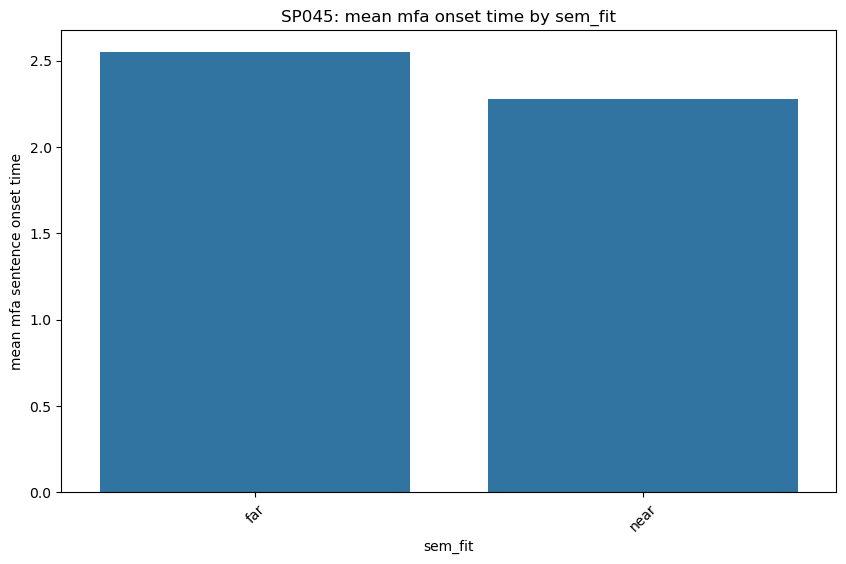

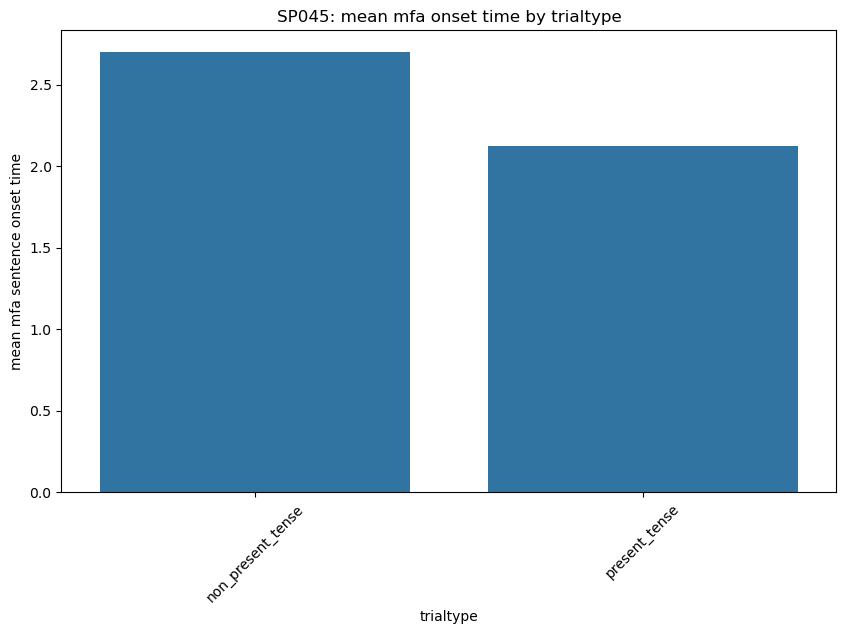

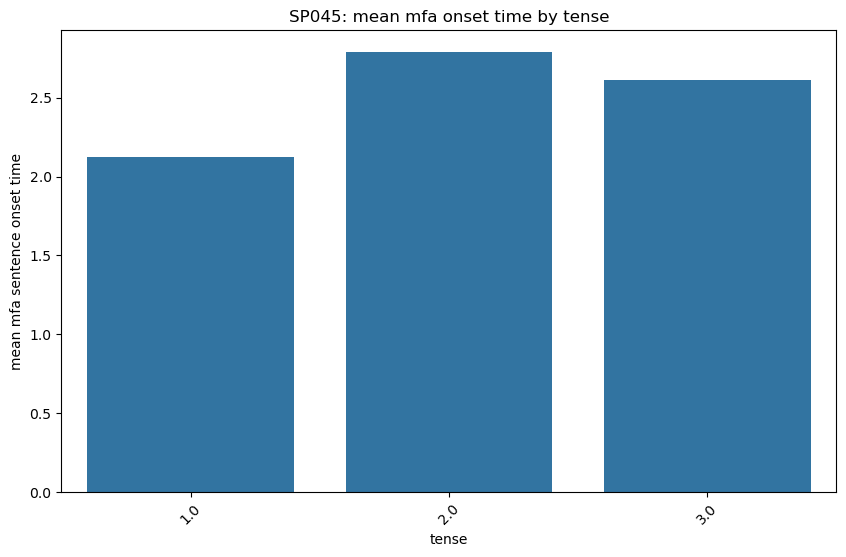

In [225]:
subject_id = subject_id
# whether to plot by 'trialtype' or 'tense', 'sem_fit'
conditions = ['sem_fit', 'trialtype', 'tense']
subject_folder = os.path.join(data_dir,subject_id)

for subfolder in ['4a','4c']:
        subfolder_path = os.path.join(data_dir, subject_folder, subfolder)
        print(subfolder_path)
        if os.path.exists(subfolder_path):
            print("yes")
            results = pd.read_csv(os.path.join(subfolder_path, f'{subject_id}_Exp4_adjustedSentenceOnsetTime.csv'))
            results = results.loc[results['sem_fit'] != 'practice']

for condition in conditions:
    mean_mfa_onset_time = results.groupby(condition).agg({'MFA_sentence_onset':'mean'}).reset_index()
    # mean_mfa_onset_time['MFA_sentence_onset']=mean_mfa_onset_time['MFA_sentence_onset']
    
    # plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=condition, y='MFA_sentence_onset', data=mean_mfa_onset_time, errorbar='sd')
    plt.title(f"{subject_id}: mean mfa onset time by {condition}")
    plt.xlabel(condition)
    plt.ylabel("mean mfa sentence onset time")
    # plt.ylim(0.75,1.5)
    plt.xticks(rotation=45)
    plt.show()

### plot group data

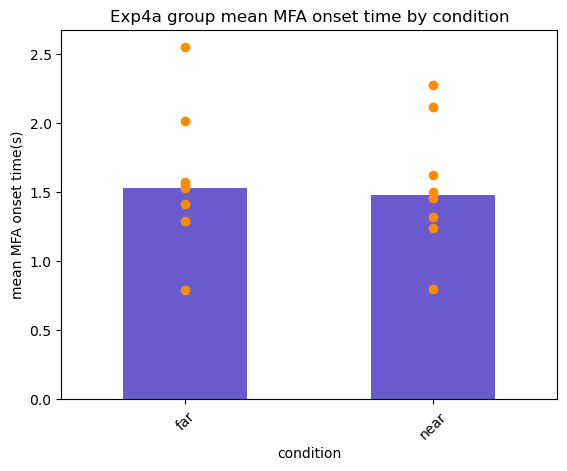

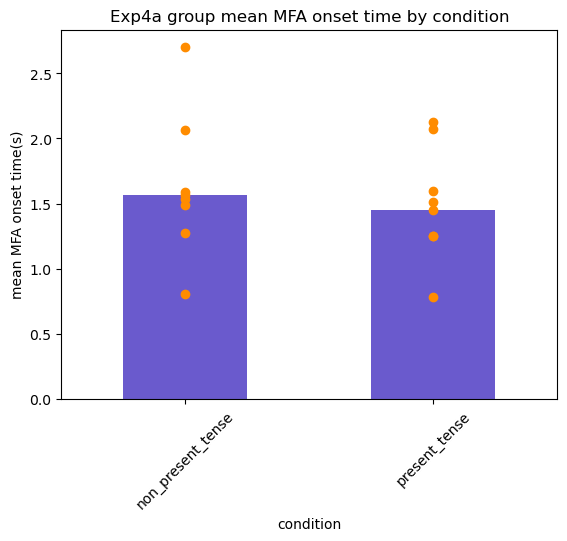

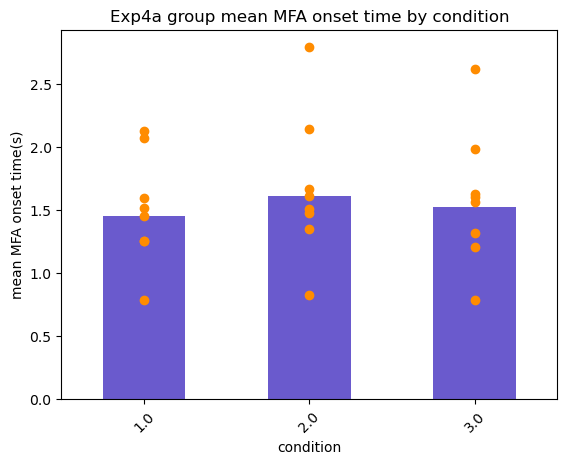

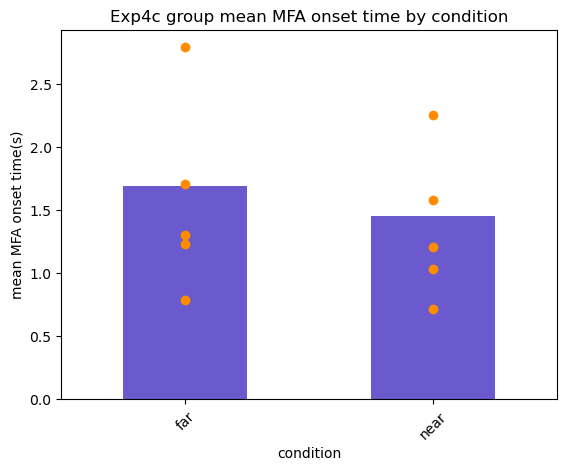

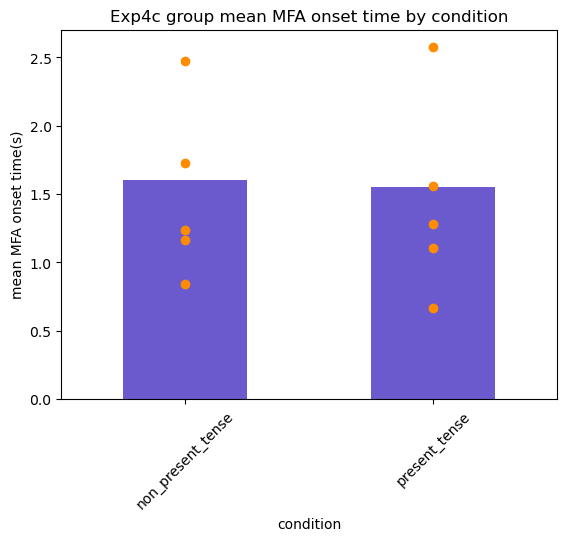

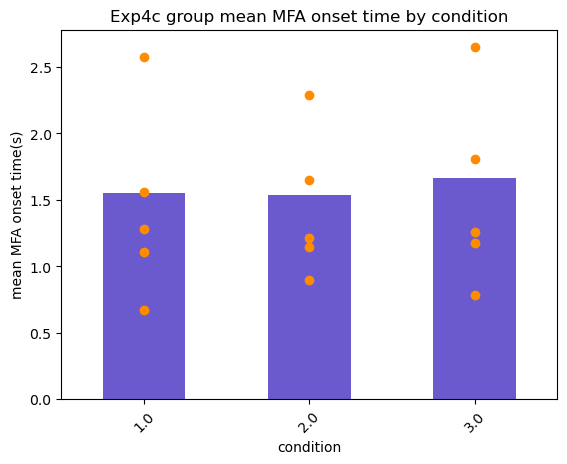

In [228]:
subject_folders = [item for item in os.listdir(data_dir) if item.startswith('SP')]
# print(subject_folders)

group_df = []

for subject_folder in subject_folders:
    if subject_folder != 'SP022' and subject_folder != 'SP026':
    # print(subject_folder)
        for subfolder in ['4a','4c']:
            subfolder_path = os.path.join(data_dir, subject_folder, subfolder)
            if subfolder_path:
                # print(subfolder_path)
                csv_file = glob(os.path.join(subfolder_path, "*_adjustedSentenceOnsetTime.csv"))
                # print(csv_file)
                if csv_file:
                    csv_file = csv_file[0]
                    # print(csv_file)
                    df = pd.read_csv(csv_file)
                group_df.append(df)

all_data = pd.concat(group_df, ignore_index=True)
all_data = all_data.loc[all_data['sem_fit'] != 'practice']
all_data['tense'] = all_data['tense'].astype(str)

for subfolder in ['4a', '4c']:
    all_data_subfolder = all_data[all_data['sub_folder'] == subfolder]
    for condition in conditions:   
        group_average = all_data_subfolder.groupby(condition)['MFA_sentence_onset'].mean()
        subject_average = all_data_subfolder.groupby(['subject', condition])['MFA_sentence_onset'].mean()
    
        group_plot = group_average.plot(kind='bar', color = '#6A5ACD')
    
        for IV in group_average.index:
            # print(IV)
            IV_data = subject_average[subject_average.index.get_level_values(condition) == IV]
            # print(IV_data)
            group_plot.scatter([IV] * len(IV_data), IV_data.values, color = '#FF8C00')
            # print(IV_data.values)
    
        plt.xlabel('condition')
        plt.ylabel('mean MFA onset time(s)')
        plt.title(f'Exp{subfolder} group mean MFA onset time by condition')
        plt.xticks(rotation=45)
        plt.show()   


        

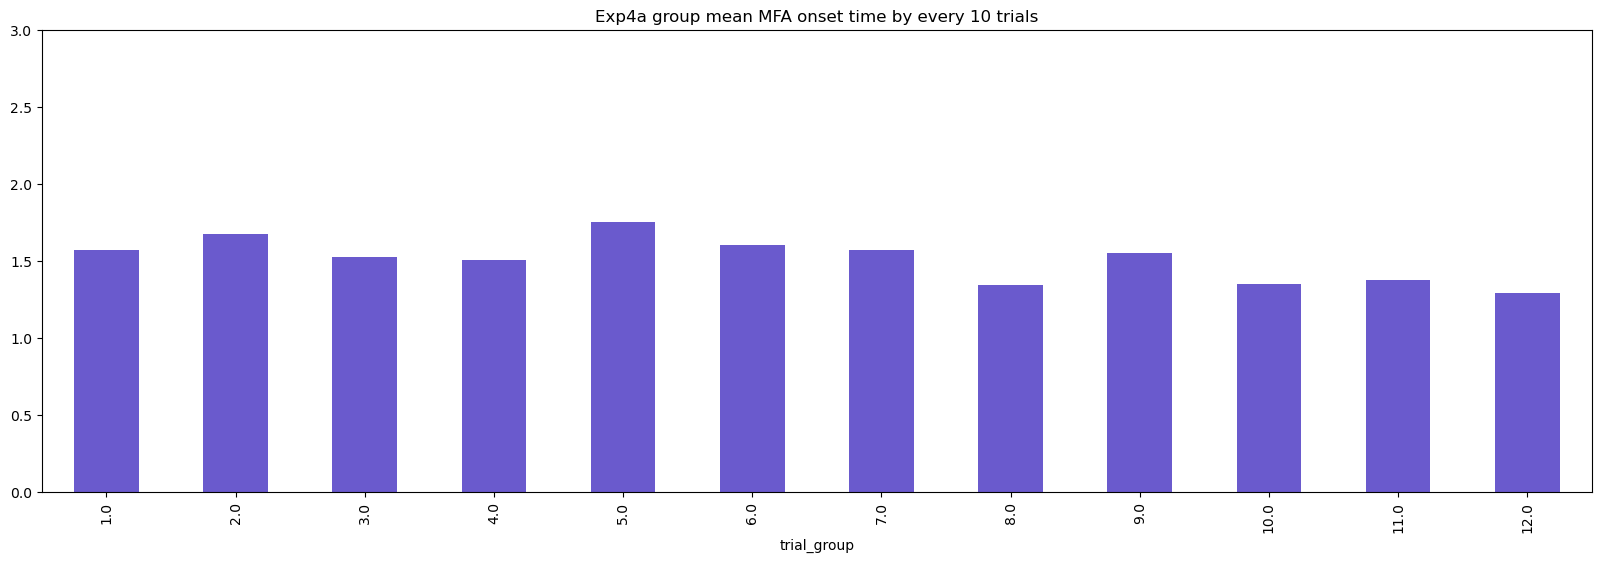

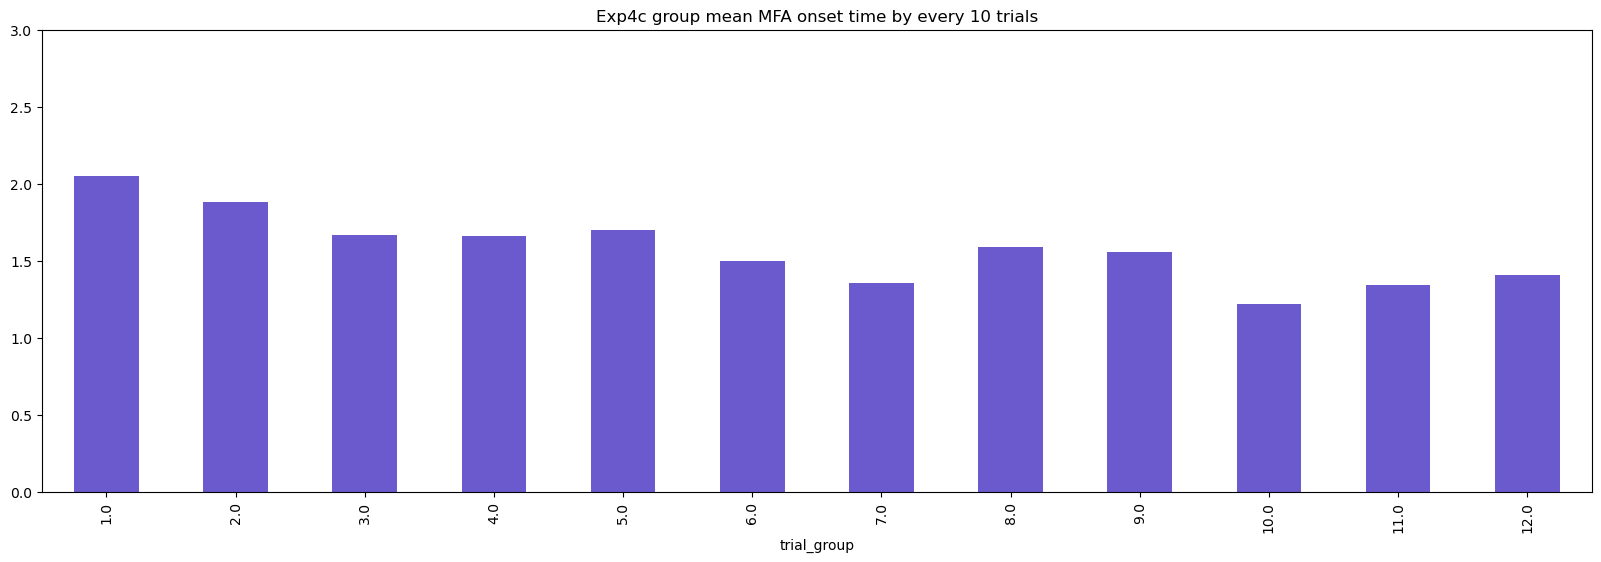

In [229]:
for subfolder in ['4a', '4c']:
    all_data_subfolder = all_data[all_data['sub_folder'] == subfolder]
    trial_average = all_data_subfolder.groupby(['trialorder'])['MFA_sentence_onset'].mean().reset_index()
    # print(trial_average)
    trial_average['trial_group'] = (trial_average['trialorder']-1) // 10 + 1

    trial_average_group = trial_average.groupby(['trial_group'])['MFA_sentence_onset'].mean()
    # print(trial_average_group)

    plt.figure(figsize=(20, 6))
    trial_plot = trial_average_group.plot(kind='bar', color = '#6A5ACD')
    plt.title(f'Exp{subfolder} group mean MFA onset time by every 10 trials')
    plt.ylim(0,3)
    plt.show()


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(all_data_subfolder.sort_values(by='trialorder'))